In [54]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pandas as pd
import sys
import os
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import to_timestamp
import time
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, Pipeline

import datetime
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second
from pyspark.mllib.stat import Statistics
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [30]:
spark = SparkSession.builder.appName('data-cleaning').\
                        config("spark.executor.instances", '3').\
                        config("spark.executor.memory", '40g').\
                        config('spark.executor.cores', '5').\
                        config('spark.cores.max', '5').appName('data_clean').\
                        getOrCreate()

In [31]:
sqlContext = SQLContext(spark.sparkContext)

In [32]:
train_data = spark.read.format('csv').option('header', 'true').load('../modeled_data/train_with_geo.csv')

In [33]:
train_data.count()

129799

In [34]:
train_data = train_data.drop('latitude18').drop('longitude19').drop('_c0').withColumnRenamed('latitude5', 'latitude').withColumnRenamed('longitude4', 'longitude')
train_data.limit(5).toPandas()

,app_id,device_id,label_id,event_id,longitude,latitude,is_active,age,is_installed,day,...,second,gender,group,category,phone_brand,device_model,town,country,category_mapped,town_index
0,-1.4565846e+17,-4.968155e+18,713.0,4633.0,116.38,39.96,0,53,1,1,...,6,F,F43+,Services 1,Huawei,荣耀6 Plus,Beijing,China,industry,35
1,-1.4565846e+17,-4.968155e+18,704.0,4633.0,116.38,39.96,0,53,1,1,...,6,F,F43+,Property Industry 2.0,Huawei,荣耀6 Plus,Beijing,China,industry,35
2,-1.4565846e+17,-4.968155e+18,548.0,4633.0,116.38,39.96,0,53,1,1,...,6,F,F43+,Industry tag,Huawei,荣耀6 Plus,Beijing,China,industry,35
3,-1.4565846e+17,-4.968155e+18,302.0,4633.0,116.38,39.96,0,53,1,1,...,6,F,F43+,unknown,Huawei,荣耀6 Plus,Beijing,China,other,35
4,-1.4565846e+17,-4.968155e+18,303.0,4633.0,116.38,39.96,0,53,1,1,...,6,F,F43+,unknown,Huawei,荣耀6 Plus,Beijing,China,other,35


In [35]:
training, test = train_data.randomSplit([0.8, 0.2], 0)

In [36]:
training.count()

103743

In [37]:
test.count()

26056

In [38]:
from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType

float_columns = ['device_id', 'app_id', 'label_id', 'event_id', 'longitude', 'latitude']
int_columns = ['is_active', 'age', 'is_installed', 'day', 'hour', 'minute', 'second', 'town_index']
string_columns = ['gender', 'group', 'category', 'phone_brand', 'device_model', 'town', 'country', 'category_mapped']

training = train_data.select(*(col(c).cast("float").alias(c) for c in float_columns), \
                                                 *(col(c).cast("int").alias(c) for c in int_columns), \
                                                 *(col(c).alias(c) for c in string_columns))
test = train_data.select(*(col(c).cast("float").alias(c) for c in float_columns), \
                                                 *(col(c).cast("int").alias(c) for c in int_columns), \
                                                 *(col(c).alias(c) for c in string_columns))

In [39]:
training.printSchema()

root
 |-- device_id: float (nullable = true)
 |-- app_id: float (nullable = true)
 |-- label_id: float (nullable = true)
 |-- event_id: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- is_active: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- is_installed: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)
 |-- town_index: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- group: string (nullable = true)
 |-- category: string (nullable = true)
 |-- phone_brand: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- town: string (nullable = true)
 |-- country: string (nullable = true)
 |-- category_mapped: string (nullable = true)



In [40]:
#Correlation
indexer = feature.StringIndexer(inputCol="gender", outputCol="gender_label")
category = feature.StringIndexer(inputCol='category', outputCol='category_encoded')
brand = feature.StringIndexer(inputCol='phone_brand', outputCol='phone_brand_encoded')
group = feature.StringIndexer(inputCol='group', outputCol='group_encoded')
is_active = feature.StringIndexer(inputCol='is_active', outputCol='is_active_encoded')
device_model = feature.StringIndexer(inputCol='device_model', outputCol='device_model_encoded')
town_model = feature.StringIndexer(inputCol='town', outputCol='town_encoded')
country_model = feature.StringIndexer(inputCol='country', outputCol='country_encoded')
category_wide = feature.StringIndexer(inputCol='category_mapped', outputCol='category_wide_encoded')

correlation_pipeline = Pipeline(stages=[indexer, category,category_wide, brand, group, is_active, device_model, town_model, country_model])
encoded_data = correlation_pipeline.fit(training).transform(training)

encoded_data = encoded_data['gender_label','device_id', 'app_id', 'category_encoded', 'category_wide_encoded', 'phone_brand_encoded', 'group_encoded', 'is_active_encoded', 'device_model_encoded',\
                           'town_encoded', 'country_encoded', 'label_id', 'event_id', 'longitude', 'latitude', 'day', 'hour', 'minute']
col_names = encoded_data.columns
features = encoded_data.rdd.map(lambda row: row[0:])
features
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)

corr_df.columns = col_names

corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,gender_label,device_id,app_id,category_encoded,category_wide_encoded,phone_brand_encoded,group_encoded,is_active_encoded,device_model_encoded,town_encoded,country_encoded,label_id,event_id,longitude,latitude,day,hour,minute
gender_label,1,-0.0123441,-0.0763094,-0.0757437,-0.0304742,-0.0896518,0.982115,0.101637,-0.0280416,-0.048966,-0.0121401,-0.116086,-0.10406,-0.1363,-0.134951,-0.0432172,-0.0366689,-0.125478
device_id,-0.0123441,1,-0.0446485,-0.0572844,-0.0610008,-0.113086,-0.0216202,-0.0913961,-0.127875,-0.139675,0.00630207,-0.021329,-0.0732815,-0.0823933,-0.113348,0.00100395,-0.0572541,-0.0480757
app_id,-0.0763094,-0.0446485,1,-0.159293,-0.10246,-0.0889731,-0.0725894,0.164964,-0.091652,-0.0878734,-0.0327369,-0.00810048,-0.076317,-0.0601184,-0.0742402,-0.0573504,-0.0358597,-0.123867
category_encoded,-0.0757437,-0.0572844,-0.159293,1,0.674407,-0.121338,-0.0671431,-0.244096,-0.149631,-0.109863,-0.0416088,-0.322033,-0.0647157,-0.0394829,-0.0543213,-0.0825513,-0.0707079,-0.0270581
category_wide_encoded,-0.0304742,-0.0610008,-0.10246,0.674407,1,-0.0833611,-0.00723525,-0.101419,-0.103654,-0.0719999,-0.0458204,-0.657922,-0.0581539,-0.0157839,-0.0203534,-0.0785096,-0.0399693,-0.0488013
phone_brand_encoded,-0.0896518,-0.113086,-0.0889731,-0.121338,-0.0833611,1,-0.0693071,0.01132,0.782085,0.0546235,0.0813295,-0.0357203,-0.0727693,-0.300708,-0.290707,-0.150859,-0.15688,-0.0985559
group_encoded,0.982115,-0.0216202,-0.0725894,-0.0671431,-0.00723525,-0.0693071,1,0.100674,-0.0308452,-0.0406986,-0.0393557,-0.141948,-0.102168,-0.117263,-0.125539,-0.0435603,-0.0266053,-0.132863
is_active_encoded,0.101637,-0.0913961,0.164964,-0.244096,-0.101419,0.01132,0.100674,1,0.0404643,-0.0303046,-0.0207062,-0.11605,-0.10015,-0.126932,-0.127579,-0.0747599,0.147054,-0.186221
device_model_encoded,-0.0280416,-0.127875,-0.091652,-0.149631,-0.103654,0.782085,-0.0308452,0.0404643,1,0.139095,0.0394289,-0.0515719,-0.0873293,-0.245086,-0.224714,-0.145875,-0.172629,-0.11446
town_encoded,-0.048966,-0.139675,-0.0878734,-0.109863,-0.0719999,0.0546235,-0.0406986,-0.0303046,0.139095,1,-0.133602,-0.0598902,-0.0772688,0.126309,0.20479,-0.136861,-0.138245,-0.1127


In [41]:
from pyspark.ml import Pipeline
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator

In [42]:
#Logistic
indexer = feature.StringIndexer(inputCol="gender", outputCol="gender_label")
category = feature.StringIndexer(inputCol='category', outputCol='category_encoded')
brand = feature.StringIndexer(inputCol='phone_brand', outputCol='phone_brand_encoded')
group = feature.StringIndexer(inputCol='group', outputCol='group_encoded')
is_active = feature.StringIndexer(inputCol='is_active', outputCol='is_active_encoded')
device_model = feature.StringIndexer(inputCol='device_model', outputCol='device_model_encoded')
town_model = feature.StringIndexer(inputCol='town', outputCol='town_encoded')
country_model = feature.StringIndexer(inputCol='country', outputCol='country_encoded')
category_wide = feature.StringIndexer(inputCol='category_mapped', outputCol='category_wide_encoded')

vector_assembler = feature.VectorAssembler(inputCols=['device_id', 'app_id', 'label_id', 'event_id', 'longitude', 'latitude', 'is_active', 'age', 
                                                            'day', 'hour', 'minute', 'second', 'category_encoded', 'category_wide_encoded', 'phone_brand_encoded',\
                                                     'is_active_encoded', 'device_model_encoded'],
                                        outputCol='features')
sc = feature.StandardScaler(inputCol='features',outputCol='sfeatures')

logistic = classification.LogisticRegression(labelCol='gender_label', featuresCol='sfeatures')

lr_model = Pipeline(stages=[indexer, category,category_wide, brand, group, is_active, device_model, town_model, country_model, vector_assembler, sc, logistic])

lr_model_p=lr_model.fit(training)

predicted = lr_model.fit(training).transform(test)


evaluator = BinaryClassificationEvaluator(labelCol='gender_label')
evaluator.evaluate(predicted)

0.5991459815762975

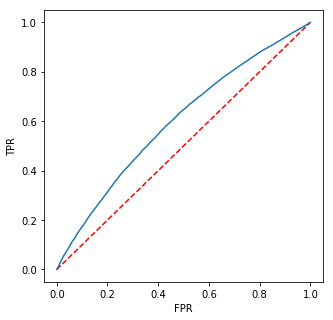

In [43]:
# ROC curve for lr


plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lr_model_p.stages[-1].summary.roc.select('FPR').collect(),
         lr_model_p.stages[-1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [44]:
#Logistic for group

indexer = feature.StringIndexer(inputCol="gender", outputCol="gender_label")
category = feature.StringIndexer(inputCol='category', outputCol='category_encoded')
brand = feature.StringIndexer(inputCol='phone_brand', outputCol='phone_brand_encoded')
group = feature.StringIndexer(inputCol='group', outputCol='group_encoded')
is_active = feature.StringIndexer(inputCol='is_active', outputCol='is_active_encoded')
device_model = feature.StringIndexer(inputCol='device_model', outputCol='device_model_encoded')
town_model = feature.StringIndexer(inputCol='town', outputCol='town_encoded')
country_model = feature.StringIndexer(inputCol='country', outputCol='country_encoded')
category_wide = feature.StringIndexer(inputCol='category_mapped', outputCol='category_wide_encoded')

vector_assembler = feature.VectorAssembler(inputCols=['device_id', 'app_id', 'label_id', 'event_id', 'longitude', 'latitude', 'is_active', 
                                                            'day', 'hour', 'minute', 'second', 'category_encoded', 'category_wide_encoded', 'phone_brand_encoded',\
                                                     'is_active_encoded', 'device_model_encoded'],
                                        outputCol='features')

sc = feature.StandardScaler(inputCol='features',outputCol='sfeatures')

logistic = classification.LogisticRegression(labelCol='group_encoded', featuresCol='features')

lr_model = Pipeline(stages=[indexer, category,category_wide, brand, group, is_active, device_model, town_model, country_model, vector_assembler, sc, logistic])

lr_model_p2=lr_model.fit(training)

predicted = lr_model.fit(training).transform(test)


evaluator = BinaryClassificationEvaluator(labelCol='group_encoded')
evaluator.evaluate(predicted)

0.4708247144047566

In [45]:
#Random Forest
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator

indexer = feature.StringIndexer(inputCol="gender", outputCol="gender_label")
category = feature.StringIndexer(inputCol='category', outputCol='category_encoded')
brand = feature.StringIndexer(inputCol='phone_brand', outputCol='phone_brand_encoded')
group = feature.StringIndexer(inputCol='group', outputCol='group_encoded')
is_active = feature.StringIndexer(inputCol='is_active', outputCol='is_active_encoded')
device_model = feature.StringIndexer(inputCol='device_model', outputCol='device_model_encoded')
town_model = feature.StringIndexer(inputCol='town', outputCol='town_encoded')
country_model = feature.StringIndexer(inputCol='country', outputCol='country_encoded')
category_wide = feature.StringIndexer(inputCol='category_mapped', outputCol='category_wide_encoded')

vector_assembler = feature.VectorAssembler(inputCols=['device_id', 'app_id', 'label_id', 'event_id', 'longitude', 'latitude', 'is_active', 'age', 
                                                            'day', 'hour', 'minute', 'second', 'category_wide_encoded', 'phone_brand_encoded',\
                                                     'is_active_encoded'],
                                        outputCol='features')

sc = feature.StandardScaler(inputCol='features',outputCol='sfeatures')

rf = classification.RandomForestClassifier(labelCol='gender_label', featuresCol='sfeatures')

random_forest_pipeline = Pipeline(stages=[indexer, category_wide, brand, group, is_active, device_model, country_model, vector_assembler, sc, rf])

random_forest_pipeline_p=random_forest_pipeline.fit(training)

rf_prediction = random_forest_pipeline.fit(training).transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='gender_label')
evaluator.evaluate(rf_prediction)

0.721456584979605

In [ ]:
#Random Forest for group

from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator

indexer = feature.StringIndexer(inputCol="gender", outputCol="gender_label")
category = feature.StringIndexer(inputCol='category', outputCol='category_encoded')
brand = feature.StringIndexer(inputCol='phone_brand', outputCol='phone_brand_encoded')
group = feature.StringIndexer(inputCol='group', outputCol='group_encoded')
is_active = feature.StringIndexer(inputCol='is_active', outputCol='is_active_encoded')
device_model = feature.StringIndexer(inputCol='device_model', outputCol='device_model_encoded')
town_model = feature.StringIndexer(inputCol='town', outputCol='town_encoded')
country_model = feature.StringIndexer(inputCol='country', outputCol='country_encoded')
category_wide = feature.StringIndexer(inputCol='category_mapped', outputCol='category_wide_encoded')

vector_assembler = feature.VectorAssembler(inputCols=['device_id', 'app_id', 'label_id', 'event_id', 'longitude', 'latitude', 'is_active', 
                                                            'day', 'hour', 'minute', 'second', 'category_wide_encoded', 'phone_brand_encoded',\
                                                     'is_active_encoded'],
                                        outputCol='features')

rf = classification.RandomForestClassifier(labelCol='group_encoded', featuresCol='features')
random_forest_pipeline = Pipeline(stages=[indexer, category_wide, brand, group, is_active, device_model, country_model, vector_assembler, rf])
rf_prediction = random_forest_pipeline.fit(training).transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='group_encoded')
evaluator.evaluate(rf_prediction)

In [51]:
# GBT Classifier for gender label

indexer = feature.StringIndexer(inputCol="gender", outputCol="gender_label")
category = feature.StringIndexer(inputCol='category', outputCol='category_encoded')
brand = feature.StringIndexer(inputCol='phone_brand', outputCol='phone_brand_encoded')
group = feature.StringIndexer(inputCol='group', outputCol='group_encoded')
is_active = feature.StringIndexer(inputCol='is_active', outputCol='is_active_encoded')
device_model = feature.StringIndexer(inputCol='device_model', outputCol='device_model_encoded')
town_model = feature.StringIndexer(inputCol='town', outputCol='town_encoded')
country_model = feature.StringIndexer(inputCol='country', outputCol='country_encoded')
category_wide = feature.StringIndexer(inputCol='category_mapped', outputCol='category_wide_encoded')

vector_assembler = feature.VectorAssembler(inputCols=['device_id', 'app_id', 'label_id', 'event_id', 'longitude', 'latitude', 'is_active', 'age', 
                                                            'day', 'hour', 'minute', 'second', 'category_wide_encoded', 'phone_brand_encoded',\
                                                     'is_active_encoded'],
                                        outputCol='features')

sc = feature.StandardScaler(inputCol='features',outputCol='sfeatures')

gbt = classification.GBTClassifier(labelCol='gender_label', featuresCol='sfeatures')

gbt_pipeline = Pipeline(stages=[indexer, category_wide, brand, group, is_active, device_model, country_model, vector_assembler, sc, gbt])

# mlp_p=random_forest_pipeline.fit(training)

gbt_prediction = gbt_pipeline.fit(training).transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='gender_label')
evaluator.evaluate(gbt_prediction)

0.8187784863979444

In [62]:
# 10-cross validator for lr

lr = logistic
grid = ParamGridBuilder().addGrid(10, [0, 1]).build()
evaluator = BinaryClassificationEvaluator(labelCol='gender_label')
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

cv_pipeline= Pipeline(stages=[indexer, category_wide, brand, group, is_active, device_model, country_model, vector_assembler, sc, cv])

cv_Model=cv_pipeline.fit(training)

evaluator.evaluate(cv_Model.transform(test))

0.49454083122656256

In [63]:
# 10 - cross validator in rf

cv = CrossValidator(estimator=rf, estimatorParamMaps=grid, evaluator=evaluator)

cv_pipeline= Pipeline(stages=[indexer, category_wide, brand, group, is_active, device_model, country_model, vector_assembler, sc, cv])

cv_Model=cv_pipeline.fit(training)

evaluator.evaluate(cv_Model.transform(test))

0.7214565849796046

In [64]:
# 10 - cross validator in gbt

cv = CrossValidator(estimator=gbt, estimatorParamMaps=grid, evaluator=evaluator)

cv_pipeline= Pipeline(stages=[indexer, category_wide, brand, group, is_active, device_model, country_model, vector_assembler, sc, cv])

cv_Model=cv_pipeline.fit(training)

evaluator.evaluate(cv_Model.transform(test))

0.818778486397948